In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#CNN+GRU

In questo tipo di approccio La rete convoluzionale è utilizzata per estrarre una nuova rappresentazione delle features fornite in ingresso, per poi essere fornita in ingresso a dei layer GRU.

La rappresentazione verra estrapolata in corrispondenza degi layer "Dense" in quanto abbiamo bisogno di una rapresentazione 1-D per fornirla in input ad dei layers GRU.

# Librerie

In [ ]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
import tensorflow

# Preparazione dei dati

Importazione del dataset "speech_signal_features_V1s". Questo dataset contiene le features estratte dai seguenti dataset: Ravdess, SAVEE, TESS, CREMA-D. Le features in questione sono:
- Zero crossing rate
- Root mean square error
- MFFCs

In [ ]:
Features_df = pd.read_csv('/content/drive/MyDrive/speech_signal_features_V1.csv')
Features_df

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.331543,0.471680,0.564941,0.452148,0.374512,0.296875,0.265137,0.256348,0.252441,0.251953,...,-1.517647,-1.716411,-1.599245,-1.234544,-0.693115,-0.038821,0.675410,1.405862,2.112551,surprise
1,0.251953,0.373535,0.494141,0.501465,0.482910,0.482422,0.476562,0.463379,0.469238,0.466309,...,-1.614816,-3.268710,-2.181269,-4.098365,-5.258773,-5.286760,-6.192348,-1.996428,2.875362,surprise
2,0.299805,0.419922,0.525879,0.459473,0.378418,0.326172,0.282227,0.260254,0.258789,0.253906,...,0.518934,0.839123,1.308966,1.855113,2.404974,2.896071,3.282975,3.541090,3.666844,surprise
3,0.261719,0.388672,0.513184,0.509277,0.500977,0.496582,0.486816,0.487793,0.479980,0.491699,...,-1.774671,-1.750296,1.640066,1.664761,0.510230,1.624107,0.165312,-0.924339,-2.566185,surprise
4,0.400879,0.591309,0.783203,0.777832,0.771973,0.777832,0.771973,0.775391,0.758789,0.580078,...,2.585885,2.746578,2.223155,0.986784,-0.730885,-2.531058,-4.002847,-4.849191,-4.929410,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48643,0.026855,0.044434,0.062012,0.060547,0.064453,0.059570,0.074219,0.113281,0.133301,0.141113,...,-2.997387,-2.857280,-0.232463,-1.449387,3.244326,3.075974,5.609814,8.831363,-1.798762,angry
48644,0.023926,0.035156,0.040527,0.035645,0.032715,0.029297,0.032715,0.048340,0.125488,0.214844,...,-5.741305,-4.147367,-7.531296,-3.492054,-2.512286,-11.724421,-7.290385,1.041336,1.246793,happy
48645,0.025879,0.053711,0.087402,0.104004,0.103027,0.083008,0.062012,0.067383,0.142090,0.231445,...,-5.524943,-8.097495,-2.270405,-1.362404,-6.644628,-5.624853,-5.777763,-5.503017,-2.788878,happy
48646,0.022461,0.034668,0.041992,0.038086,0.038086,0.034668,0.036133,0.044434,0.117676,0.207031,...,-4.208822,3.741516,-2.212307,1.554494,-3.257353,-17.360359,-1.698290,6.971038,-4.712044,happy


Di seguito è riportato il controllo relativo ai valori NaN all'interno del dataset. Nel caso fossero presenti sono sostituiti con valori nulli

In [ ]:
Features_df.isna().values.any()

True

In [ ]:
Features_df=Features_df.fillna(0)
np.sum(Features_df.isna())

0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

In [ ]:
Features_df.isna().values.any()

False

A questo punto vengono creati i set di training e di testing

In [ ]:
X = Features_df.iloc[: ,:-1].values
Y = Features_df['Emotions'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray().astype(int)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 3)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(38918, 2376)
(38918, 7)
(9730, 2376)
(9730, 7)


In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

Dato che questo tipo di architetture prende in input una sequenza in questo caso non serve aggiungere una dimensione fittizia ai nostri dati

#Architettura CNN+GRU

In [ ]:
from keras import layers, optimizers
def build_model(input_shape):
    model = tensorflow.keras.Sequential()

    model.add(Conv1D(128, 3, activation = "relu",input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2))

    model.add(Conv1D(128, 3, activation = "relu"))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2))

    model.add(layers.Dense(128, activation='relu'))
    model.add(Dropout(0.3))

    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(layers.GRU(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(layers.GRU(128,return_sequences=False))
    model.add(Dropout(0.2))

    model.add(layers.Dense(7, activation='softmax'))

    return model

In [ ]:
model = build_model((x_train.shape[1],1))

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 2374, 128)         512       
                                                                 
 batch_normalization_4 (Bat  (None, 2374, 128)         512       
 chNormalization)                                                
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 1187, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 1185, 128)         49280     
                                                                 
 batch_normalization_5 (Bat  (None, 1185, 128)         512       
 chNormalization)                                                
                                                      

In [ ]:
hist=model.fit(x_train, y_train,
            epochs=50,
            validation_data=(x_test, y_test),batch_size=64,
            verbose=1)

Epoch 1/50
609/609 [==============================] - 69s 101ms/step - loss: 1.8981 - accuracy: 0.1781 - val_loss: 1.8856 - val_accuracy: 0.1872
Epoch 2/50
609/609 [==============================] - 60s 98ms/step - loss: 1.8826 - accuracy: 0.1890 - val_loss: 1.8798 - val_accuracy: 0.1936
Epoch 3/50
609/609 [==============================] - 61s 99ms/step - loss: 1.8723 - accuracy: 0.1942 - val_loss: 1.8551 - val_accuracy: 0.2246
Epoch 4/50
609/609 [==============================] - 61s 99ms/step - loss: 1.6918 - accuracy: 0.3032 - val_loss: 1.4969 - val_accuracy: 0.3960
Epoch 5/50
609/609 [==============================] - 60s 99ms/step - loss: 1.3684 - accuracy: 0.4537 - val_loss: 1.2105 - val_accuracy: 0.5221
Epoch 6/50
609/609 [==============================] - 60s 99ms/step - loss: 1.1923 - accuracy: 0.5328 - val_loss: 1.1515 - val_accuracy: 0.5471
Epoch 7/50
609/609 [==============================] - 61s 100ms/step - loss: 1.1017 - accuracy: 0.5710 - val_loss: 1.1139 - val_accurac

305/305 [==============================] - 8s 24ms/step - loss: 0.5563 - accuracy: 0.8181
Accuratezza del modello sulla base dei dati di test:  81.80884122848511 %


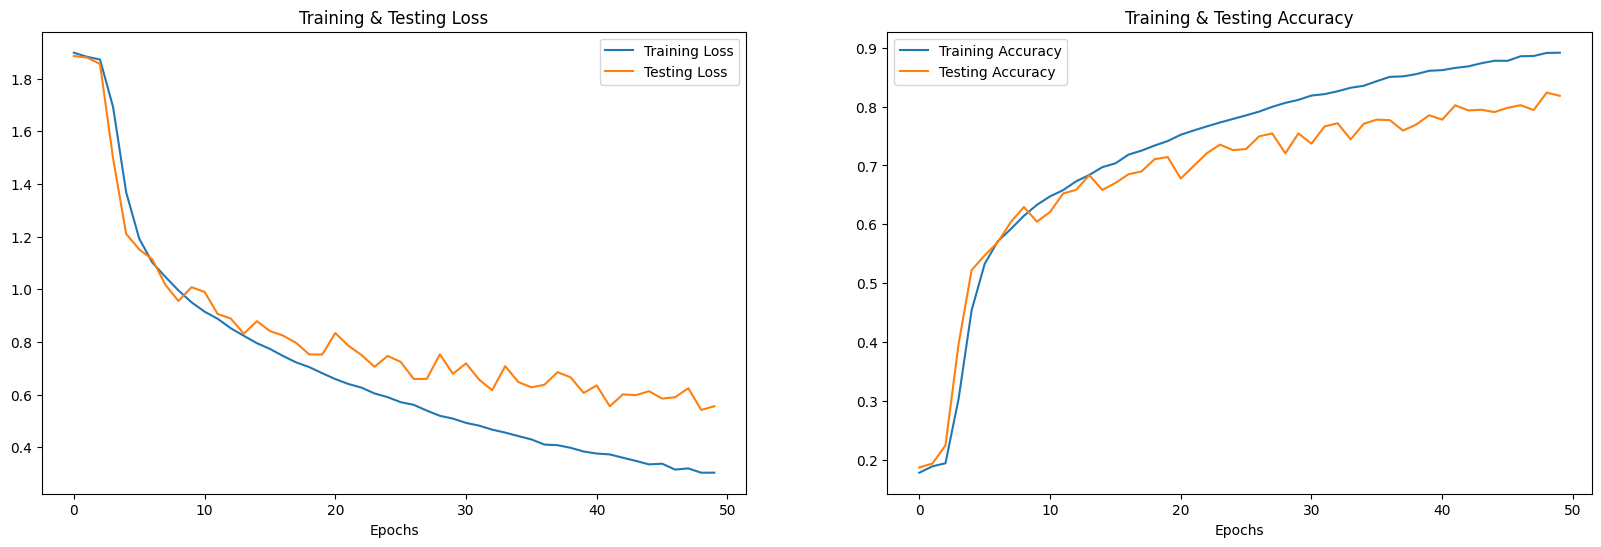

In [ ]:
print("Accuratezza del modello sulla base dei dati di test: " , model.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
test_acc = hist.history['val_accuracy']
test_loss = hist.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Evaluation model

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

305/305 [==============================] - 7s 22ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,sad,sad
2,neutral,neutral
3,sad,sad
4,angry,angry
5,sad,sad
6,fear,fear
7,sad,neutral
8,angry,angry
9,sad,sad


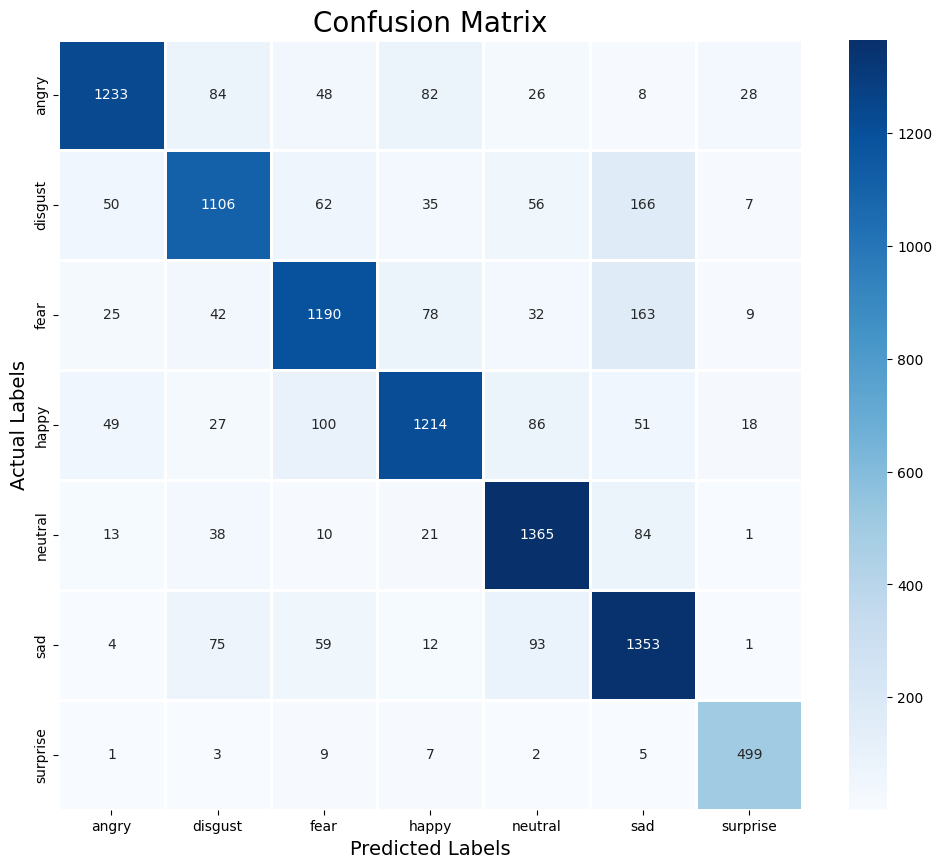

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.90      0.82      0.86      1509
     disgust       0.80      0.75      0.77      1482
        fear       0.81      0.77      0.79      1539
       happy       0.84      0.79      0.81      1545
     neutral       0.82      0.89      0.86      1532
         sad       0.74      0.85      0.79      1597
    surprise       0.89      0.95      0.92       526

    accuracy                           0.82      9730
   macro avg       0.83      0.83      0.83      9730
weighted avg       0.82      0.82      0.82      9730



# Saving model

In [ ]:
model.save(os.path.join('models','Speech_signal_features_V1_CNN+GRU.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
